In [33]:
import models
import numpy as np
import os
import sys
import config_vmc as cv_module
from numba import jit
from scipy.linalg import schur
from copy import deepcopy
@jit(nopython=True)
def from_linearized_index(index, L, n_orbitals, n_sublattices = 2):
    orbit = index % n_orbitals
    coord = index // n_orbitals
    sublattice = coord % n_sublattices
    coord = coord // n_sublattices

    x = coord // L
    y = coord % L
    return orbit, sublattice, x, y


@jit(nopython=True)
def to_linearized_index(x, y, sublattice, orbit, L, n_orbitals, n_sublattices = 2):
    return orbit + n_orbitals * (sublattice + n_sublattices * (y + x * L))

@jit(nopython=True)
def nearest_neighbor_hexagonal(r1, r2, L):
    if r1[1] == r2[1] and r1[0] == r2[0]:
        return True, 1
    if r1[1] == r2[1] and diff_modulo(r1[0], r2[0], L, 1):
        return True, 2
    if r1[0] == r2[0] and diff_modulo(r1[1], r2[1], L, 1):
        return True, 3
    return False, 0

@jit(nopython=True)
def next_nearest_neighbor_hexagonal(r1, r2, L):
    if r1[0] == r2[0] and diff_modulo(r1[1], r2[1], L, 1):
        return True, 1

    if diff_modulo(r1[0], r2[0], L, 1) and r1[1] == r2[1]:
        return True, 2

    if r1[0] == r2[0] and diff_modulo(r1[1], r2[1], L, -1):
        return True, 4

    if diff_modulo(r1[0], r2[0], L, -1) and r1[1] == r2[1]:
        return True, 5

    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, -1):
        return True, 3

    if diff_modulo(r1[0], r2[0], L, -1) and diff_modulo(r1[1], r2[1], L, 1):
        return True, 6

    return False, -1


@jit(nopython=True)
def third_nearest_neighbor(r1, r2, L):
    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, -1):
        return True
    if diff_modulo(r1[0], r2[0], L, 0) and diff_modulo(r1[1], r2[1], L, -1):
        return True
    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, 0):
        return True
    return False


@jit(nopython=True)
def fifth_nearest_neighbor(r1, r2, L):
    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, -2):
        return True
    if diff_modulo(r1[0], r2[0], L, -2) and diff_modulo(r1[1], r2[1], L, 1):
        return True
    if diff_modulo(r1[0], r2[0], L, 1) and diff_modulo(r1[1], r2[1], L, 1):
        return True
    return False

@jit(nopython=True)
def diff_modulo(x, y, L, d):
    if d >= 0:
        return (x - y + L) % L == d  # or (x - y + L) % L == L - d
    return (x - y + L) % L == L + d

@jit(nopython=True)
def _model_hex_2orb_Koshino(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2
    t1, t2, t5, t4 = 0.331, (-0.010 * 0. + 1.0j * 0.097 * 0), 0 * 0.119, 0 * 0.036


    K = np.zeros((total_dof // 2, total_dof // 2)) * 1.0j
    for first in range(total_dof // 2):
        for second in range(total_dof // 2):
            orbit1, sublattice1, x1, y1 = from_linearized_index(first, Ls, n_orbitals, n_sublattices)
            orbit2, sublattice2, x2, y2 = from_linearized_index(second, Ls, n_orbitals, n_sublattices)

            r1 = np.array([x1, y1])
            r2 = np.array([x2, y2])

            if orbit1 == orbit2 and nearest_neighbor_hexagonal(r1, r2, Ls)[0] and sublattice1 == 0 and sublattice2 == 1:
                K[first, second] += t1

            if orbit2 == orbit1 and fifth_nearest_neighbor(r1, r2, Ls) and sublattice2 == sublattice1:
                K[first, second] += np.real(t2)
            if orbit2 != orbit1 and fifth_nearest_neighbor(r1, r2, Ls) and sublattice2 == sublattice1:
                if orbit1 == 0 and orbit2 == 1:
                    K[first, second] += np.imag(t2)
                else:
                    K[first, second] += -np.imag(t2)

    K = K + K.conj().T
    return K


def import_config(filename: str):
    import importlib

    module_name, extension = os.path.splitext(os.path.basename(filename))
    module_dir = os.path.dirname(filename)
    if extension != ".py":
        raise ValueError(
            "Could not import the module from {!r}: not a Python source file.".format(
                filename
            )
        )
    if not os.path.exists(filename):
        raise ValueError(
            "Could not import the module from {!r}: no such file or directory".format(
                filename
            )
        )
    sys.path.insert(0, module_dir)
    module = importlib.import_module(module_name)
    sys.path.pop(0)
    return module

@jit(nopython=True)
def get_fft(N, n_bands):
    W = np.zeros((N ** 2, N ** 2), dtype=np.complex128)
    for kx in range(N):
        for ky in range(N):
            for x in range(N):
                for y in range(N):
                    W[x * N + y, kx * N + ky] = np.exp(2.0j * np.pi / N * kx * x + 2.0j * np.pi / N * ky * y)
    return np.kron(W, np.eye(n_bands)) / N / np.sqrt(n_bands)
L = 4

@jit(nopython=True)
def fermi(energy, beta):
    return 1 / (1. + np.exp(energy * beta))

@jit(nopython=True)
def lattice_to_physical(lattice):
    x = (lattice[0] + lattice[1]) * np.sqrt(3) / 2
    y = (lattice[0] - lattice[1]) / 2

    if lattice[2] == 1:
        x += 1. / np.sqrt(3)
    return np.array([x, y])

@jit(nopython=True)
def physical_to_lattice(physical):
    x, y = physical
    lattice = [0, 0, 0]
    if np.abs(int(np.rint(2 * x.real / np.sqrt(3))) - 2 * x.real / np.sqrt(3)) >= 1e-5:
        lattice[2] = 1
        x = x - 1. / np.sqrt(3)


    lattice[1] = int(np.rint((x.real - np.sqrt(3) * y.real) / np.sqrt(3)))
    lattice[0] = int(np.rint((x.real + np.sqrt(3) * y.real) / np.sqrt(3)))

    #print(physical, lattice, (x.real + np.sqrt(3) * y.real) / np.sqrt(3), (x.real - np.sqrt(3) * y.real) / np.sqrt(3))
    return np.array(lattice)

@jit(nopython=True)
def get_C3z_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2

    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping
    rotation_matrix = np.array([[np.cos(2 * np.pi / 3.), np.sin(2 * np.pi / 3.)], \
                                [-np.sin(2 * np.pi / 3.), np.cos(2 * np.pi / 3.)]], dtype=np.complex128)
    rotation_matrix_orbital = np.array([[np.exp(-2.0j * np.pi / 3), 0], [0, np.exp(2.0j * np.pi / 3)]])

    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)

        orbit_preimage_vector = np.zeros(n_orbitals, dtype=np.complex128); orbit_preimage_vector[orbit_preimage] = 1.
        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)

        orbit_image_vector = rotation_matrix_orbital.dot(orbit_preimage_vector) #np.einsum('ij,j->i', rotation_matrix_orbital, orbit_preimage_vector)

        r_image = rotation_matrix.dot(r_preimage)#np.einsum('ij,j->i', rotation_matrix, r_preimage)
        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        #print(r_preimage, '-->', r_image)
        # print(sublattice_preimage, x_preimage, y_preimage, '-->', sublattice_image, x_image, y_image)
        x_image = int(np.rint(x_image)) % Ls; y_image = int(np.rint(y_image)) % Ls
        
        for orbit_image in range(n_orbitals):
            coefficient = orbit_image_vector[orbit_image]
            index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                               Ls, n_orbitals, n_sublattices)
            #if coefficient != 0.:
            #    print(preindex, '-->', index)
            mapping[preindex, index] += coefficient
                
    assert np.sum(np.abs(mapping.dot(mapping).dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_3z^3 = I
    return mapping

@jit(nopython=True)
def get_C2y_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2
    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping

    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)     

        orbit_image = 1 - orbit_preimage
        coefficient = -1.0

        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)
        r_preimage -= np.array([1. / np.sqrt(3) / 2, 0.0])
        r_image = np.array([-r_preimage[0], r_preimage[1]]) + np.array([1. / np.sqrt(3) / 2, 0.0])

        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        x_image = int(np.rint(x_image)); y_image = int(np.rint(y_image))
        x_image = (x_image % Ls); y_image = (y_image % Ls)
        
        index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                           Ls, n_orbitals, n_sublattices)

        mapping[preindex, index] += coefficient

    assert np.sum(np.abs(mapping.dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_2y^2 = I
    return mapping + 0.0j

@jit(nopython=True)
def get_TRS_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2
    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping

    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)     

        orbit_image = 1 - orbit_preimage

        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)
        r_image = r_preimage

        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        x_image = int(np.rint(x_image)); y_image = int(np.rint(y_image))
        x_image = (x_image % Ls); y_image = (y_image % Ls)
        
        index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                           Ls, n_orbitals, n_sublattices)

        mapping[preindex, index] += 1

    assert np.sum(np.abs(mapping.dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_2y^2 = I
    return mapping + 0.0j


@jit(nopython=True)
def get_Tx_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2

    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping
    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)

        orbit_preimage_vector = np.zeros(n_orbitals, dtype=np.complex128); orbit_preimage_vector[orbit_preimage] = 1.
        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)

        orbit_image_vector = orbit_preimage_vector

        r_image = r_preimage + np.array([np.sqrt(3), 1]) / 2. #rotation_matrix.dot(r_preimage)#np.einsum('ij,j->i', rotation_matrix, r_preimage)
        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        #print(r_preimage, '-->', r_image)
        # print(sublattice_preimage, x_preimage, y_preimage, '-->', sublattice_image, x_image, y_image)
        x_image = int(np.rint(x_image)) % Ls; y_image = int(np.rint(y_image)) % Ls
        
        for orbit_image in range(n_orbitals):
            coefficient = orbit_image_vector[orbit_image]
            index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                               Ls, n_orbitals, n_sublattices)
            mapping[preindex, index] += coefficient
                
    #assert np.sum(np.abs(mapping.dot(mapping).dot(mapping).dot(mapping).dot(mapping).dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_3z^3 = I
    return mapping

@jit(nopython=True)
def get_Ty_symmetry_map(Ls):
    n_orbitals = 2
    n_sublattices = 2
    total_dof = Ls ** 2 * n_orbitals * n_sublattices * 2

    mapping = np.zeros((total_dof // 2, total_dof // 2), dtype=np.complex128)  # trivial mapping
    for preindex in range(total_dof // 2):
        orbit_preimage, sublattice_preimage, x_preimage, y_preimage = \
            from_linearized_index(preindex, Ls, n_orbitals, n_sublattices)

        orbit_preimage_vector = np.zeros(n_orbitals, dtype=np.complex128); orbit_preimage_vector[orbit_preimage] = 1.
        r_preimage = lattice_to_physical([x_preimage, y_preimage, sublattice_preimage]).astype(np.complex128)

        orbit_image_vector = orbit_preimage_vector

        r_image = r_preimage + np.array([np.sqrt(3), -1]) / 2. #rotation_matrix.dot(r_preimage)#np.einsum('ij,j->i', rotation_matrix, r_preimage)
        x_image, y_image, sublattice_image = physical_to_lattice(r_image)
        #print(r_preimage, '-->', r_image)
        # print(sublattice_preimage, x_preimage, y_preimage, '-->', sublattice_image, x_image, y_image)
        x_image = int(np.rint(x_image)) % Ls; y_image = int(np.rint(y_image)) % Ls
        
        for orbit_image in range(n_orbitals):
            coefficient = orbit_image_vector[orbit_image]
            index = to_linearized_index(x_image, y_image, sublattice_image, orbit_image, \
                                               Ls, n_orbitals, n_sublattices)
            mapping[preindex, index] += coefficient
                
    #assert np.sum(np.abs(mapping.dot(mapping).dot(mapping).dot(mapping).dot(mapping).dot(mapping) - np.eye(mapping.shape[0]))) < 1e-5  # C_3z^3 = I
    return mapping

In [34]:
n_bands = 4
fft = get_fft(L, n_bands)

In [35]:
Ls = L
mapping = get_C3z_symmetry_map(L)
C2 = get_C2y_symmetry_map(L)

Tx = get_Tx_symmetry_map(L)
Ty = get_Ty_symmetry_map(L)
K0 = _model_hex_2orb_Koshino(L)
U_xy_to_chiral = np.kron(np.eye(K0.shape[0] // 2), np.array([[1, 1], [-1.0j, +1.0j]]) / np.sqrt(2))

K0 = U_xy_to_chiral.conj().T.dot(K0).dot(U_xy_to_chiral)
print(np.dot(K0.conj().flatten(), mapping.dot(K0).dot(mapping.T.conj()).flatten()) / np.dot(K0.conj().flatten(), K0.flatten()))
assert np.isclose(np.dot(K0.conj().flatten(), mapping.dot(K0).dot(mapping.T.conj()).flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1)
assert np.isclose(np.dot(K0.conj().flatten(), Tx.dot(K0).dot(Tx.T.conj()).flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1)
assert np.isclose(np.dot(K0.conj().flatten(), Ty.dot(K0).dot(Ty.T.conj()).flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1)
TRS = np.concatenate([np.array([2 * i + 1, 2 * i]) for i in range(K0.shape[0] // 2)])
assert np.allclose(K0, K0.conj().T)

K0_TRS = K0[TRS, :]
K0_TRS = K0_TRS[:, TRS].conj()

assert np.isclose(np.vdot(K0.flatten(), K0_TRS.flatten()) / np.dot(K0.conj().flatten(), K0.flatten()), 1.0)
TRS = get_TRS_symmetry_map(L)

K0_plus = K0[::2, :]
K0_plus = K0_plus[:, ::2]

K0_minus = K0[1::2, :]
K0_minus = K0_minus[:, 1::2]

assert np.allclose(K0_plus, K0_minus.conj())
assert np.allclose(np.linalg.eigh(K0_plus)[0], np.linalg.eigh(K0_minus)[0])


beta = 0.01


K0 = K0 - np.diag(np.diag(K0) + 0.20)
energies = np.linalg.eigh(K0)[0]
print(energies)
### doing the FFT of K0 ###
K0_fft = fft.conj().T.dot(K0).dot(fft)
print(K0_fft[:4, :4])
K0_fft_plus = K0_fft[::2, :]
K0_fft_plus = K0_fft_plus[:, ::2]

K0_fft_minus = K0_fft[1::2, :]
K0_fft_minus = K0_fft_minus[:, 1::2]

assert np.allclose(K0_fft_plus, K0_fft_plus.conj().T)
assert np.allclose(K0_fft_minus, K0_fft_minus.conj().T)

# assert np.allclose(K0_fft_plus, K0_fft_minus.conj())
K0_check = K0_fft.copy()
for i in range(K0_check.shape[0] // n_bands):
    K0_check[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands] = 0.0
assert np.isclose(np.sum(np.abs(K0_check)), 0.0)

#print(np.unique(K0))
#print(np.unique(K0_fft))


A = np.zeros((L, L, n_bands, n_bands), dtype=np.complex128)
energies = np.zeros((L, L, n_bands), dtype=np.complex128)

energies_plus = np.zeros((L, L, n_bands // 2), dtype=np.float64)
energies_minus = np.zeros((L, L, n_bands // 2), dtype=np.float64)
for i in range(K0_check.shape[0] // n_bands):
    kx, ky = i % L, i // L
    mat = K0_fft[i * n_bands:i * n_bands + n_bands,i * n_bands:i * n_bands + n_bands]
    assert np.allclose(mat.conj().T, mat)
    
    
    A[kx, ky, ...] = np.linalg.eigh(mat)[1]
    
    nonch = 0
    for a in range(n_bands):
        for b in range(n_bands):
            if (a + b) % 2 == 1:
                nonch += np.abs(mat[a, b])
    assert np.isclose(nonch, 0.0)
    
    
    energies[kx, ky, ...] = np.linalg.eigh(mat)[0]
    energies_plus[kx, ky, ...] = \
        np.linalg.eigh(K0_fft_plus[i * n_bands // 2:i * n_bands // 2 + n_bands // 2, \
                                   i * n_bands // 2:i * n_bands // 2 + n_bands // 2])[0].real
    #print(K0_fft_plus[i * n_bands // 2:i * n_bands // 2 + n_bands // 2, \
    #                               i * n_bands // 2:i * n_bands // 2 + n_bands // 2])
    #print(K0_fft_minus[i * n_bands // 2:i * n_bands // 2 + n_bands // 2, \
    #                                i * n_bands // 2:i * n_bands // 2 + n_bands // 2])
    energies_minus[kx, ky, ...] = \
        np.linalg.eigh(K0_fft_minus[i * n_bands // 2:i * n_bands // 2 + n_bands // 2, \
                                    i * n_bands // 2:i * n_bands // 2 + n_bands // 2])[0].real

#print(np.sort(energies.flatten()))
##print(np.sort(energies_plus.flatten()), np.sort(energies_minus.flatten()))
print(np.sort(energies_plus.flatten()) - np.sort(energies_minus.flatten()))
assert np.allclose(np.sort(energies_plus.flatten()), np.sort(energies_minus.flatten()))
@jit(nopython=True)
def get_susc_zero(Ls, n_bands, A, A_plus_q, energies, energies_plus_q, omega, temp):
    chi = np.zeros((n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
    for kx in range(Ls):
        for ky in range(Ls):
            for alpha in range(n_bands):
                for beta in range(n_bands):
                    for p in range(n_bands):
                        for q in range(n_bands):
                            for s in range(n_bands):
                                for t in range(n_bands):
                                    chi[p, q, s, t] -= A[kx, ky, s, alpha] * \
                                               np.conj(A[kx, ky, p, alpha]) * \
                                                       A_plus_q[kx, ky, q, beta] * \
                                               np.conj(A_plus_q[kx, ky, t, beta]) / \
                                                (omega + energies_plus_q[kx, ky, beta] - energies[kx, ky, alpha] + 1e-8j) * \
                                                (fermi(energies_plus_q[kx, ky, beta], temp) - fermi(energies[kx, ky, alpha], temp))

    return chi / n_bands / Ls ** 2

susc_0 = np.zeros((L, L, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
for qx in range(Ls):
    for qy in range(Ls):
        A_plus_q = np.roll(A, shift = -qx, axis=0) 
        A_plus_q = np.roll(A_plus_q, shift = -qy, axis=1)
    
        energies_plus_q = np.roll(energies, shift = -qx, axis=0)
        energies_plus_q = np.roll(energies_plus_q, shift = -qy, axis=1)
        susc_0[qx, qy, ...] = get_susc_zero(Ls, n_bands, A, A_plus_q, energies, energies_plus_q, 0., beta)
        
        for a in range(n_bands):
            for b in range(n_bands):
                for c in range(n_bands):
                    for d in range(n_bands):
                        if (a + d) % 2 != (b + c) % 2:
                            assert np.isclose(susc_0[qx, qy, a, b, c, d], 0.0)
                        
susc_uniform = np.sum(susc_0[:, :, np.arange(n_bands), np.arange(n_bands), :, :], axis=2)
susc_uniform = np.sum(susc_uniform[:, :, np.arange(n_bands), np.arange(n_bands)], axis=-1).real
#print(np.sum(np.abs(A.real)))



'''
vol = Ls ** 2 * n_bands

susc0_full = np.zeros((vol, vol, vol, vol), dtype=np.complex128)

for i in range(Ls ** 2):
    susc0_full[i * n_bands : i * n_bands + n_bands, \
                i * n_bands : i * n_bands + n_bands, \
                i * n_bands : i * n_bands + n_bands, \
                i * n_bands : i * n_bands + n_bands] = \
            susc_0[i // Ls, i % Ls, ...].reshape((n_bands, n_bands, n_bands, n_bands))

susc0_realspace = np.einsum('abcd,ai->ibcd', susc0_full, fft)
susc0_realspace = np.einsum('ibcd,bj->ijcd', susc0_realspace, fft.conj())
susc0_realspace = np.einsum('ijcd,ck->ijkd', susc0_realspace, fft.conj())
susc0_realspace = np.einsum('ijkd,dl->ijkl', susc0_realspace, fft)

susc0_realspace_C3 = np.einsum('abcd,ai->ibcd', susc0_realspace, mapping)
susc0_realspace_C3 = np.einsum('ibcd,bj->ijcd', susc0_realspace_C3, mapping.conj())
susc0_realspace_C3 = np.einsum('ijcd,ck->ijkd', susc0_realspace_C3, mapping.conj())
susc0_realspace_C3 = np.einsum('ijkd,dl->ijkl', susc0_realspace_C3, mapping)

print(np.vdot(susc0_realspace.flatten(), susc0_realspace_C3.flatten()) / np.vdot(susc0_realspace.flatten(), susc0_realspace.flatten()))
'''

(0.9999999999999994+0j)
[-1.193     -1.193     -0.9401385 -0.9401385 -0.9401385 -0.9401385
 -0.9401385 -0.9401385 -0.9401385 -0.9401385 -0.9401385 -0.9401385
 -0.9401385 -0.9401385 -0.531     -0.531     -0.531     -0.531
 -0.531     -0.531     -0.531     -0.531     -0.531     -0.531
 -0.531     -0.531     -0.531     -0.531     -0.531     -0.531
 -0.531     -0.531      0.131      0.131      0.131      0.131
  0.131      0.131      0.131      0.131      0.131      0.131
  0.131      0.131      0.131      0.131      0.131      0.131
  0.131      0.131      0.5401385  0.5401385  0.5401385  0.5401385
  0.5401385  0.5401385  0.5401385  0.5401385  0.5401385  0.5401385
  0.5401385  0.5401385  0.793      0.793    ]
[[-0.05   +0.j  0.     +0.j  0.24825+0.j  0.     +0.j]
 [ 0.     +0.j -0.05   +0.j  0.     +0.j  0.24825+0.j]
 [ 0.24825+0.j  0.     +0.j -0.05   +0.j  0.     +0.j]
 [ 0.     +0.j  0.24825+0.j  0.     +0.j -0.05   +0.j]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

"\nvol = Ls ** 2 * n_bands\n\nsusc0_full = np.zeros((vol, vol, vol, vol), dtype=np.complex128)\n\nfor i in range(Ls ** 2):\n    susc0_full[i * n_bands : i * n_bands + n_bands,                 i * n_bands : i * n_bands + n_bands,                 i * n_bands : i * n_bands + n_bands,                 i * n_bands : i * n_bands + n_bands] =             susc_0[i // Ls, i % Ls, ...].reshape((n_bands, n_bands, n_bands, n_bands))\n\nsusc0_realspace = np.einsum('abcd,ai->ibcd', susc0_full, fft)\nsusc0_realspace = np.einsum('ibcd,bj->ijcd', susc0_realspace, fft.conj())\nsusc0_realspace = np.einsum('ijcd,ck->ijkd', susc0_realspace, fft.conj())\nsusc0_realspace = np.einsum('ijkd,dl->ijkl', susc0_realspace, fft)\n\nsusc0_realspace_C3 = np.einsum('abcd,ai->ibcd', susc0_realspace, mapping)\nsusc0_realspace_C3 = np.einsum('ibcd,bj->ijcd', susc0_realspace_C3, mapping.conj())\nsusc0_realspace_C3 = np.einsum('ijcd,ck->ijkd', susc0_realspace_C3, mapping.conj())\nsusc0_realspace_C3 = np.einsum('ijkd,dl->ijkl

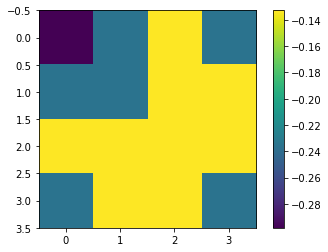

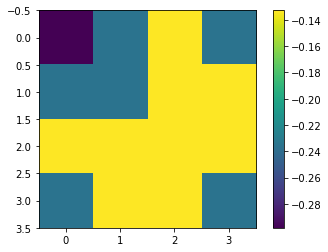

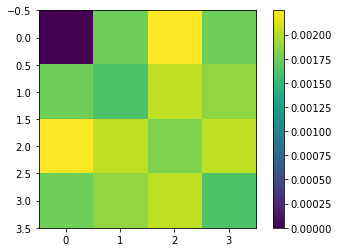

-2.9032077508286456

In [36]:
import matplotlib.pyplot as plt
plt.imshow(energies_plus[..., 0].real, interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(energies_minus[..., 0].real, interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(susc_uniform, interpolation='nearest')
plt.colorbar()
plt.show()


np.sum(energies_minus[..., 0].real)

In [72]:
Alat = np.array([[np.sqrt(3) / 2., 1. / 2.], [np.sqrt(3) / 2., -1. / 2.]])
G = 2 * np.pi * np.array([[1. / np.sqrt(3), +1], [1. / np.sqrt(3), -1.]])  # is this momentum compatible?

print(Alat.dot(G) /2 / np.pi)

def get_interaction(n_bands, qx, qy, U, J):
    U_total = np.zeros((2 * n_bands, 2 * n_bands, 2 * n_bands, 2 * n_bands), dtype=np.complex128)
    q_phys = (G[0] * qx + G[1] * qy) / L
    exp_q1 = np.exp(1.0j * np.dot(q_phys, Alat[0]))
    exp_q2 = np.exp(1.0j * np.dot(q_phys, Alat[1]))
    #print(exp_q1, exp_q2)

    '''
    for band in range(4):
        U_total[band, band, band + 4, band + 4] += -U
        U_total[band + 4, band, band + 4, band] += +U
        U_total[band, band + 4, band, band + 4] += +U
        U_total[band + 4, band + 4, band, band] += -U
        
    for band in range(4):
        U_total[band + 4, band + 4, band, band] += -U
        U_total[band, band + 4, band, band + 4] += +U
        U_total[band + 4, band, band + 4, band] += +U
        U_total[band, band, band + 4, band + 4] += -U

    for subl in range(2):
        for nu in range(2):
            nubar = 1 - nu
            band = subl * 2 + nu
            bandbar = subl * 2 + nubar
            
            for s in range(2):
                for sbar in range(2):
                    U_total[band + 4 * s, band + 4 * s, bandbar + 4 * sbar, bandbar + 4 * sbar] += -U
                    U_total[bandbar + 4 * sbar, band + 4 * s, bandbar + 4 * sbar, band + 4 * s] += +U
                    U_total[band + 4 * s, bandbar + 4 * sbar, band + 4 * s, bandbar + 4 * sbar] += +U
                    U_total[bandbar + 4 * sbar, bandbar + 4 * sbar, band + 4 * s, band + 4 * s] += -U
    '''
    AB_factor = (1. + exp_q1 + exp_q2) / 2
    BA_factor = np.conj(AB_factor)
    
    for nuA in range(2):
        for nuB in range(2):
            for sA in range(2):
                for sB in range(2):
                    U_total[0 * 2 + nuA + 4 * sA, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuB + 4 * sB] = -J * AB_factor
                    #U_total[1 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA] = +J * AB_factor
                    #U_total[0 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB] = +J * AB_factor
                    #U_total[1 * 2 + nuB + 4 * sB, 0 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA, 0 * 2 + nuA + 4 * sA] = -J * AB_factor
                    
                    U_total[1 * 2 + nuA + 4 * sA, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuB + 4 * sB] = -J * BA_factor
                    #U_total[0 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 1 * 2 + nuA + 4 * sA] = +J * BA_factor
                    #U_total[1 * 2 + nuA + 4 * sA, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 0 * 2 + nuB + 4 * sB] = +J * BA_factor
                    #U_total[0 * 2 + nuB + 4 * sB, 1 * 2 + nuB + 4 * sB, 0 * 2 + nuA + 4 * sA, 1 * 2 + nuA + 4 * sA] = -J * BA_factor      
                    
    assert np.allclose(U_total, U_total.transpose((3, 2, 1, 0)).conj())    
    return U_total


U_s = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
U_c = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
U_t = np.zeros((Ls, Ls, 2 * n_bands, 2 * n_bands, 2 * n_bands, 2 * n_bands), dtype=np.complex128)

chi_s = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
chi_c = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)


U = 0.9
J = 0.0
for qx in range(Ls):
    for qy in range(Ls):
        inter = get_interaction(n_bands, qx, qy, U, J)
        U_s[qx, qy, ...] = inter[:4, :4, :4, :4] - inter[:4, :4, 4:, 4:]
        U_c[qx, qy, ...] = -inter[:4, :4, :4, :4] - inter[:4, :4, 4:, 4:]
        U_t[qx, qy, ...] = inter
        
        chi_s[qx, qy, ...] = (np.linalg.inv(np.eye(n_bands ** 2) - susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))) @ susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))
        chi_c[qx, qy, ...] = (np.linalg.inv(np.eye(n_bands ** 2) + susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))) @ susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))

        for a in range(4):
            for b in range(4):
                for c in range(4):
                    for d in range(4):
                        if (a + c) % 2 != (b + d) %2:
                            assert np.isclose(chi_c[qx, qy, a, b, c, d], 0.0)
                            assert np.isclose(chi_s[qx, qy, a, b, c, d], 0.0)
        # after interaction account, still converve valley number
green = np.zeros((Ls, Ls, n_bands, n_bands), dtype=np.complex128)

for kx in range(Ls):
    for ky in range(Ls):
        for a in range(n_bands):
            for b in range(n_bands):
                for band in range(n_bands):
                    green[kx, ky, a, b] += A[kx, ky, a, band] * \
                                   np.conj(A[kx, ky, b, band]) / \
                                  (-energies[kx, ky, band].real)
                if (a + b) % 2 == 1:
                    #print(green[kx, ky, a, b])
                    assert np.isclose(green[kx, ky, a, b], 0.)
print(U_c[0, 0, :2, :2, :2, :2].reshape((4, 4)))

[[0.78867513 0.3660254 ]
 [0.21132487 1.3660254 ]]
[[-0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j -0.-0.j]]


In [75]:
Gsinglet = np.zeros((Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)

for qx in range(Ls):
    for qy in range(Ls):
        Gsinglet[qx, qy, ...] = (0 * 3. / 2. * U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) + \
                                 U_s[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) / 2. + U_s[qx, qy, ...].transpose((3, 1, 2, 0)).reshape((n_bands ** 2, n_bands ** 2)) / 2. + \
                                 U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) / 2. + U_c[qx, qy, ...].transpose((3, 1, 2, 0)).reshape((n_bands ** 2, n_bands ** 2)) / 2. - \
                                 0 * 1. / 2. * U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ susc_0[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2)) @ U_c[qx, qy, ...].reshape((n_bands ** 2, n_bands ** 2))).reshape((n_bands, n_bands, n_bands, n_bands))

@jit(nopython=True)
def construct_op(Ls, n_bands, Gsinglet, beta, green):
    op = np.zeros((Ls, Ls, Ls, Ls, n_bands, n_bands, n_bands, n_bands), dtype=np.complex128)
    for kx in range(Ls):
        for ky in range(Ls):
            for qx in range(Ls):
                for qy in range(Ls):
                    for abar in range(n_bands):
                        for bbar in range(n_bands):
                            for cbar in range(n_bands):
                                for dbar in range(n_bands):
                                    for a in range(n_bands):
                                        for b in range(n_bands):
                                            op[kx, ky, qx, qy, abar, bbar, cbar, dbar] -= 1. / Ls ** 2 / beta * \
                                                   Gsinglet[kx - qx, ky - qy, a, abar, bbar, b] * \
                                                   green[qx, qy, a, cbar] * \
                                                   green[-qx, -qy, b, dbar] # FIXME --> need conj?#np.conj(green[(-qx) % Ls, (-qy) % Ls, b, dbar])
    return op


op = construct_op(Ls, n_bands, Gsinglet, beta, green)
#for kx in range(Ls):
#    for ky in range(Ls):
#        assert np.allclose(op[kx, ky, ...], op[0, 0, ...])
op = op.transpose((0, 1, 4, 5, 2, 3, 6, 7)).reshape((Ls ** 2 * n_bands ** 2, Ls ** 2 * n_bands ** 2))
vol = Ls ** 2 * n_bands


op_full = np.zeros((vol, vol, vol, vol), dtype=np.complex128)

for i in range(Ls ** 2):
    for j in range(Ls ** 2):
        op_full[i * n_bands : i * n_bands + n_bands, \
                i * n_bands : i * n_bands + n_bands, \
                j * n_bands : j * n_bands + n_bands, \
                j * n_bands : j * n_bands + n_bands] = \
            op[n_bands ** 2 * i:n_bands ** 2 * i + n_bands ** 2, \
               n_bands ** 2 * j:n_bands ** 2 * j + n_bands ** 2].reshape((n_bands, n_bands, n_bands, n_bands))
'''
op_realspace = np.einsum('abcd,ai->ibcd', op_full, fft)
op_realspace = np.einsum('ibcd,bj->ijcd', op_realspace, fft.conj())
op_realspace = np.einsum('ijcd,ck->ijkd', op_realspace, fft.conj())
op_realspace = np.einsum('ijkd,dl->ijkl', op_realspace, fft)

op_realspace_C3 = np.einsum('abcd,ai->ibcd', op_realspace, mapping.conj())
op_realspace_C3 = np.einsum('ibcd,bj->ijcd', op_realspace_C3, mapping.conj())
op_realspace_C3 = np.einsum('ijcd,ck->ijkd', op_realspace_C3, mapping)
op_realspace_C3 = np.einsum('ijkd,dl->ijkl', op_realspace_C3, mapping)
print(np.vdot(op_realspace.flatten(), op_realspace_C3.flatten()) / np.vdot(op_realspace.flatten(), op_realspace.flatten()))




op_realspace_TRS = np.einsum('abcd,ai->ibcd', op_realspace, TRS.conj())
op_realspace_TRS = np.einsum('ibcd,bj->ijcd', op_realspace_TRS, TRS.conj())
op_realspace_TRS = np.einsum('ijcd,ck->ijkd', op_realspace_TRS, TRS)
op_realspace_TRS = np.einsum('ijkd,dl->ijkl', op_realspace_TRS, TRS)
print(np.vdot(op_realspace.flatten(), op_realspace_TRS.flatten()) / np.vdot(op_realspace.flatten(), op_realspace.flatten()))


'''
#op_realspace = np.einsum('abcd,ai,bj,ck,dl->ijkl', op_full, fft, fft.conj().T, fft, fft.conj().T)


"\nop_realspace = np.einsum('abcd,ai->ibcd', op_full, fft)\nop_realspace = np.einsum('ibcd,bj->ijcd', op_realspace, fft.conj())\nop_realspace = np.einsum('ijcd,ck->ijkd', op_realspace, fft.conj())\nop_realspace = np.einsum('ijkd,dl->ijkl', op_realspace, fft)\n\nop_realspace_C3 = np.einsum('abcd,ai->ibcd', op_realspace, mapping.conj())\nop_realspace_C3 = np.einsum('ibcd,bj->ijcd', op_realspace_C3, mapping.conj())\nop_realspace_C3 = np.einsum('ijcd,ck->ijkd', op_realspace_C3, mapping)\nop_realspace_C3 = np.einsum('ijkd,dl->ijkl', op_realspace_C3, mapping)\nprint(np.vdot(op_realspace.flatten(), op_realspace_C3.flatten()) / np.vdot(op_realspace.flatten(), op_realspace.flatten()))\n\n\n\n\nop_realspace_TRS = np.einsum('abcd,ai->ibcd', op_realspace, TRS.conj())\nop_realspace_TRS = np.einsum('ibcd,bj->ijcd', op_realspace_TRS, TRS.conj())\nop_realspace_TRS = np.einsum('ijcd,ck->ijkd', op_realspace_TRS, TRS)\nop_realspace_TRS = np.einsum('ijkd,dl->ijkl', op_realspace_TRS, TRS)\nprint(np.vdot(op

In [76]:
#print(np.vdot(op_realspace.flatten(), op_realspace.transpose((1, 0, 2, 3)).flatten()) / np.vdot(op_realspace.flatten(), op_realspace.flatten()))
#print(np.vdot(op_realspace.flatten(), op_realspace.transpose((0, 1, 3, 2)).flatten()) / np.vdot(op_realspace.flatten(), op_realspace.flatten()))

In [77]:
#print(np.unique(op))

from scipy.sparse.linalg import eigsh, eigs

#op_realspace = op_realspace.reshape((vol ** 2, vol ** 2))
E, eig = np.linalg.eig(op)#eigs(op, k=6, which='LR', maxiter=100000)
#E, eig = eigs(op_realspace, k=40, which='LR', maxiter=10000)#, tol=1e-10)
#E, eig = eigs(op, k=20, which='LR', maxiter=10000000)#, tol=1e-10)
def gram_schmidt_columns(X):
    Q, R = np.linalg.qr(X)
    return Q


#for e, vec in zip(E, eig.T):
#    assert np.allclose(op.dot(vec), e * vec)
#print(np.sort(-E.real) * -1)
eig = eig[:, np.argsort(-E.real)]
E = E[np.argsort(-E.real)]
print(E.real[:100])

eig = gram_schmidt_columns(eig)

print(np.vdot(eig[:, 0], eig[:, 1]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
0j


1.0


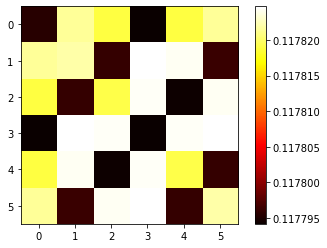

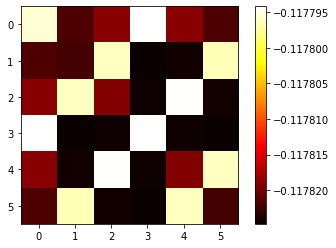

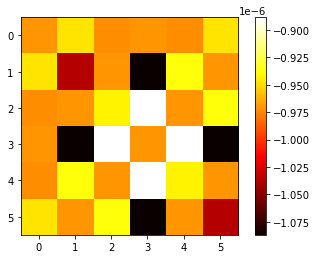

In [30]:
vec = eig[:, 0].reshape((Ls, Ls, n_bands, n_bands))[..., 0, 0].flatten()
import matplotlib.pyplot as plt

maxelem = 1.#vec[np.argmax(np.abs(vec))]
print(maxelem)
plt.imshow(np.abs(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(np.real(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

import matplotlib.pyplot as plt
plt.imshow(np.imag(vec / maxelem).reshape((Ls, Ls)), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [31]:
vals = []
c2vals = []
trsvals = []

#mapping = mapping.conj()
gaps_realspace = []
for j in range(len(E)):
    if np.abs(E[j]) < 1e-6:
        continue
    vec = eig[:, j].reshape((Ls ** 2, n_bands, n_bands))
    
    gap_matrix = np.zeros((Ls ** 2 * n_bands, Ls ** 2 * n_bands), dtype=np.complex128)
    gap_matrix_TRS = np.zeros((Ls ** 2 * n_bands, Ls ** 2 * n_bands), dtype=np.complex128)
    for i in range(Ls ** 2):
        gap_matrix[i * n_bands:i * n_bands + n_bands, \
                   i * n_bands:i * n_bands + n_bands] = vec[i, ...]
        kx = i // Ls
        ky = i % Ls
        
        kx = (-kx) % Ls
        ky = (-ky) % Ls
        
        ip = kx * Ls + ky
        gap_matrix_TRS[i * n_bands:i * n_bands + n_bands, \
                       i * n_bands:i * n_bands + n_bands] = vec[ip, ...].conj()
    #    #print(i, vec[i, ...]);# print(vec[0, ...])
    #    #assert np.allclose(vec[i, ...], vec[0, ...])

    gap_relspace = fft.dot(gap_matrix).dot(fft.conj().T)
    print('nonsinglet:', np.vdot(gap_relspace.flatten(), gap_relspace.T.flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    
    
    #for i in range(1, 2):
    #    print(repr(gap_relspace[4 * i:4 * i + 4, 4 * i + 0:4 * i + 4]))
    #gap_relspace = (gap_relspace + gap_relspace.T) / 2.
    # assert np.allclose(gap_relspace, gap_relspace.T)
    gap_relspace_TRS = fft.conj().dot(gap_matrix.conj()).dot(fft.T)
    gap_relspace_TRS_true = fft.dot(gap_matrix_TRS).dot(fft.conj().T)
    assert np.allclose(gap_relspace_TRS, gap_relspace_TRS_true)
    
    if False:# j == 0:
        for a in range(vol):
            for b in range(vol):
                atrs = (a // 2) * 2 + (1 - a % 2)
                btrs = (b // 2) * 2 + (1 - b % 2)
                
                #print(a, b, np.abs(gap_relspace[a, b] - gap_relspace[atrs, btrs]) < 1e-10)
                if np.abs(gap_relspace[b, a] - gap_relspace[atrs, btrs]) >1e-10:
                    print(a, b, gap_relspace[b, a] / gap_relspace[atrs, btrs])
    gaps_realspace.append(gap_relspace * 1.)
    #gap_relspace = vec.reshape((vol, vol))
    #print(gap_relspace[:4, :4])
    #print(gap_relspace[:4, :4] / (mapping.dot(gap_relspace).dot(mapping.T)[:4, :4] + 1e-10))
    #print(np.vdot(gap_relspace_TRS.flatten(), gap_relspace_TRS.flatten()) * 16.)
    #assert np.isclose(np.vdot(gap_relspace.flatten(), gap_relspace.flatten()) * 16., 1.0)
    assert np.isclose(np.vdot(gap_relspace_TRS.flatten(), gap_relspace_TRS.flatten()) * 16., 1.0)
    
    vals.append(np.vdot(gap_relspace.flatten(), mapping.dot(gap_relspace).dot(mapping.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    c2vals.append(np.vdot(gap_relspace.flatten(), C2.dot(gap_relspace).dot(C2.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    trsvals.append(np.vdot(gap_relspace.flatten(), TRS.dot(gap_relspace_TRS).dot(TRS.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    print(E[j], np.vdot(gap_relspace.flatten(), mapping.dot(mapping).dot(gap_relspace).dot(mapping.dot(mapping).T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), mapping.conj().dot(gap_relspace).dot(mapping.T.conj()).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), Tx.dot(gap_relspace).dot(Tx.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), Ty.dot(gap_relspace).dot(Ty.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), TRS.dot(gap_relspace_TRS).dot(TRS.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.abs(np.vdot(gap_relspace.flatten(), TRS.dot(gap_relspace_TRS).dot(TRS.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten())))
    #print(np.sum(np.abs(gap_relspace[:4, :4] - gap_relspace[4:8, 4:8])))
    print('-----')
print(np.vdot(gaps_realspace[2], gaps_realspace[3]))

        
E = np.round(E.real, decimals=3)
vals = np.array(vals)
c2vals = np.array(c2vals)
trsvals = np.array(trsvals)
for e in np.sort(-np.unique(E)):
    if np.isclose(e, 0):
        continue
    e = -e
    assert np.isclose(np.sum(vals[np.where(E == e)[0]]).imag, 0.)
    assert np.isclose( np.sum(c2vals[np.where(E == e)[0]]).imag, 0.)
    if len(np.where(E == e)[0]) == 1:
        assert np.isclose(np.abs(np.sum(trsvals[np.where(E == e)[0]])), 1.)
    
    projector_ij = np.zeros((len(np.where(E == e)[0]), len(np.where(E == e)[0])), dtype=np.complex128)
    for ii, i in enumerate(np.where(E == e)[0]):
        for jj, j in enumerate(np.where(E == e)[0]):
            projector_ij[ii, jj] = np.vdot(gaps_realspace[i], gaps_realspace[j] + gaps_realspace[j].T) / 2. * 16.
    assert np.allclose(projector_ij, projector_ij.conj().T)
    Ee, vecvec = np.linalg.eig(projector_ij)
    #print()
    #for a, b in zip(Ee, vecvec.T):
    #    print(a.real, b)
    #print(np.diag(projector_ij))
    assert np.allclose(Ee.imag * 0.0, Ee.imag)
    # print(trsvals[np.where(E == e)[0]])
    print(e, 'c3:', np.around(np.sum(vals[np.where(E == e)[0]]).real, decimals=14), \
             'c2:', np.around(np.sum(c2vals[np.where(E == e)[0]]).real, decimals=14), \
            'TRS:', np.around(np.sum(trsvals[np.where(E == e)[0]]), decimals=14) if len(np.where(E == e)[0]) == 1 else 'undef', len(np.where(E == e)[0]), np.around(Ee.real, decimals=2))

    


nonsinglet: (1-1.376428539288239e-21j)
(29472.23384941936-2.686521843155405e-13j) (-0.4996801502954967-0.8654714078454547j) (-0.49968015029549784-0.8654714078454541j) (0.9999999999999999-4.2351647362715045e-22j) (0.9999999999999999+9.529120656610884e-22j) (1.9840069746723822e-22-8.51096079501963e-22j) 8.739149691469408e-22
-----
nonsinglet: (1+8.470329472543009e-22j)
(29472.233849419248-7.712228494009652e-13j) (-0.49968015029549656+0.8654714078454548j) (-0.4996801502954977+0.8654714078454543j) (0.9999999999999999-4.2351647362715045e-22j) (1+4.2351647362715045e-22j) (-1.9840092527751684e-22-8.510964855695966e-22j) 8.739154163303754e-22
-----
nonsinglet: (0.9999999999999989+2.983724378680104e-16j)
(5053.282722813003+1.5731607089289815e-12j) (0.006029521746489756-9.080193194566086e-18j) (0.006029521746489756+9.107298248878223e-18j) (1-6.9388939039072176e-18j) (1-2.0816681711721654e-17j) (-0.8951494001832639+0.445766251920823j) 0.9999999999999979
-----
nonsinglet: (-0.9999999999999992+2.28

(1.1424686757114968-2.3674593806058633e-14j) (-0.4995771363921593-2.958769839377096e-13j) (-0.4995771363921594+2.9587629275882465e-13j) (1-3.7947076036992665e-19j) (1-3.2526065174565143e-19j) (-0.9999980661041132+0.0019666692415276094j) 0.9999999999999359
-----
nonsinglet: (-0.9999999999999986+6.866919246922435e-19j)
(1.1352992222776914+5.755878624009138e-14j) (-0.4996919871565564-1.2268305317448263e-12j) (-0.4996919871565564+1.2268294350339807e-12j) (1-9.57621276608431e-19j) (1+1.3438820070556412e-19j) (-0.9999999999999984-2.4383429848044144e-13j) 0.9999999999999984
-----
nonsinglet: (0.9999999999999984+2.7755575615628914e-17j)
(0.9809897618008542-6.3224552496371775e-15j) (-0.4318156380709143+7.197020757132577e-14j) (-0.4318156380709142-7.199449369998945e-14j) (1+1.3877787807814457e-17j) (1+6.245004513516506e-17j) (0.5555622097332246-0.831474973235114j) 0.9999999999999984
-----
nonsinglet: (0.9999999999999989-3.4694469519536134e-18j)
(0.8822434963356623-1.3314696520978376e-14j) (0.845

(0.3878356477472523-7.13318293321663e-15j) (0.24704131770720633-0.255430917617893j) (0.24704131771418913-0.2554309176219555j) (1.0000000000000002-5.204170427930418e-18j) (1+6.938893903907224e-18j) (0.231619596258626+0.7681109216215865j) 0.8022730366186888
-----
nonsinglet: (-0.9999999999981135+1.1102230246251563e-16j)
(0.3878356477472325-9.832087401184797e-16j) (0.2470413177117196+0.2554309176189651j) (0.24704131770967414+0.25543091762086506j) (1-6.938893903907227e-17j) (1.0000000000000002+0j) (0.8022714137520446+0.0016136795427637847j) 0.8022730366186882
-----
nonsinglet: (-0.9999999999999982-1.821459649775647e-17j)
(0.36722607857710166-4.6750927539799755e-15j) (-0.4820975177776723+7.81334415569934e-12j) (-0.4820975177776724-7.813345239901513e-12j) (1-3.903127820947815e-18j) (0.9999999999999998-4.336808689942017e-19j) (-0.9985866938948114+0.05314710505968597j) 0.9999999999999974
-----
nonsinglet: (0.9999999999996112-7.318364664277155e-19j)
(0.35884276974100665+1.0564885842930709e-13j)

(0.17532979237463747+6.2072997237762004e-15j) (-0.4955611421511962-8.878743227222161e-12j) (-0.4955611421511962+8.878742738713123e-12j) (1-8.958643820935661e-19j) (1+1.1001560824322674e-18j) (-0.9999999999999982-5.341115036530689e-13j) 0.9999999999999982
-----
nonsinglet: (0.9999999999999647+1.6940658945086012e-19j)
(0.1751981886468681+2.502393957449293e-15j) (-0.49852095931492135-4.670669165557189e-13j) (-0.4985209593149214+4.670662270708999e-13j) (1+8.809142651444726e-20j) (1+1.5585406229479129e-19j) (-0.9999999893667688+0.0001458300075430714j) 0.9999999999999644
-----
nonsinglet: (0.9999999999999994+3.1961545353826533e-19j)
(0.17111201673480134+4.107488120491864e-15j) (0.996036968934909+1.2016706449871588e-14j) (0.996036968934909-1.2017985209628887e-14j) (1+1.8880054436838516e-19j) (1+5.0353096820612803e-20j) (0.9999999999999993-8.893863100581527e-13j) 0.9999999999999993
-----
nonsinglet: (0.9999999999999976+1.387778780781445e-17j)
(0.16376233030958395-2.6330486080996083e-13j) (0.92

(0.11456707056849139-5.553335570981964e-13j) (0.10275382009368346+0.17671766679605952j) (0.10275382007392914+0.17671766680727521j) (1.0000000000000002-1.7347234759768068e-17j) (1-3.4694469519536136e-17j) (0.10707711036139023+0.05110872189631762j) 0.118649100364143
-----
nonsinglet: (0.9999999999969051+3.4694469519536134e-18j)
(0.11456707056644246+3.200485851623323e-13j) (0.10275382007213567-0.17671766679847603j) (0.10275382008644289-0.1767176667891863j) (1.0000000000000002-1.7347234759768068e-17j) (1.0000000000000002+1.7347234759768068e-17j) (0.11656608387529638-0.022134974750332943j) 0.11864910036414313
-----
nonsinglet: (0.9999999999870873-6.424489376594577e-20j)
(0.10957226749002894-2.7968418045038875e-14j) (-0.488697478697263+3.999324254115703e-12j) (-0.4886974786972631-3.999322908787057e-12j) (1-1.0179956414548797e-19j) (1+5.108705757591281e-19j) (0.9999999999870874+7.638631825396869e-12j) 0.9999999999870874
-----
nonsinglet: (-0.9999999999890705+2.081668171172169e-17j)
(0.1084926

(0.06842780039764335+3.091790609610345e-14j) (0.14107794768977136-0.036467130982992306j) (0.14107794768063306-0.03646713098155038j) (1.0000000000000002+0j) (1-6.93889390390723e-18j) (-0.038211568679577236+0.9880625726838156j) 0.9888011789634529
-----
nonsinglet: (-0.9999999999999942-6.93889390390723e-18j)
(0.06746648167175581+5.784592533529553e-14j) (-0.49626319744958325-3.5972249484705905e-11j) (-0.49626319744958325+3.597222866802419e-11j) (1+0j) (1-2.081668171172169e-17j) (0.7887568068965748-0.6147053762367057j) 0.9999999999999952
-----
nonsinglet: (-0.9999999999999855-2.918710891450582e-19j)
(0.05965103806929146-4.672130094788882e-15j) (0.9922711848174329-1.0558665817226163e-14j) (0.992271184817433+1.0560021764032788e-14j) (1-5.294007519415644e-19j) (1-4.2409252687074007e-20j) (-0.9999999999999849+2.139895588998498e-12j) 0.9999999999999849
-----
nonsinglet: (0.9999999999996928-6.352747104407257e-20j)
(0.05941047638810067-3.5738703863379023e-14j) (0.21449321861700635-0.37148196543137

(0.03493693046956452-3.5029894566648845e-15j) (0.21373522846275209-0.37006990486775454j) (0.21373522846010426-0.3700699048692799j) (1.0000000000000002+0j) (1-1.1858461261560212e-20j) (-0.020309779773986923+0.01707955915562886j) 0.026536738597997947
-----
nonsinglet: (-0.9999999999999594+2.7105054312137617e-20j)
(0.03493693046953336+1.5164764364250082e-15j) (0.21373522846033383+0.37006990486842334j) (0.21373522846189247+0.37006990486752334j) (1+3.388131789017202e-21j) (1+2.0328790734103214e-20j) (0.020307446011685253+0.01708233391258235j) 0.026536738597997916
-----
nonsinglet: (-0.9999999996863249-1.5612511283791267e-17j)
(0.03188443154438253-2.388063705116572e-14j) (-0.4553611302135474+0.22511343241325488j) (-0.4553611302094792+0.2251134324147246j) (1.0000000000000002+3.903127820947817e-18j) (1.0000000000000004-1.1275702593849249e-17j) (-0.8758902772851725-0.38903918305346297j) 0.9584024539793303
-----
nonsinglet: (-0.9999999996863116-1.8214596497756484e-17j)
(0.031884431544081715+1.34

(-0.01626038430682572-1.2889602579724269e-12j) (-0.49232193427951904-0.7838236349228782j) (-0.49232193428061266-0.783823634922073j) (1-4.336808689942019e-19j) (1+8.673617379884037e-19j) (0.1137807615539491-0.3770026943896247j) 0.3937982900887628
-----
nonsinglet: (0.9999999999988338+1.73472347597681e-18j)
(-0.016260384309544334+3.4776468664744013e-13j) (-0.4923219342810782+0.7838236349265987j) (-0.49232193427973747+0.7838236349267645j) (1+0j) (1-1.73472347597681e-18j) (-0.09959555517738754-0.3809958249977834j) 0.39379829008876316
-----
nonsinglet: (-0.0015304909011320384-2.3039296165316974e-19j)
(-0.019400218988852216+4.276102262128776e-15j) (0.24895827795519088-0.2889878323038956j) (0.24895827780902158-0.28898783180881327j) (1.0000000000000002-1.387778780781446e-17j) (1+3.469446951953615e-17j) (-0.0010498894386962825+0.0004035788352396386j) 0.0011247860728775844
-----
nonsinglet: (-0.0014996974803824013-1.2197274440461932e-19j)
(-0.01940021898907039+9.50012605474573e-14j) (0.248958278

(-0.03930197328383292+1.311976025622833e-13j) (0.9966127167350733+1.1774714436438816e-12j) (0.9966127167350735-1.1774711861458657e-12j) (1.0000000000000002+1.4230153513872248e-19j) (1+1.6940658945086012e-19j) (-1-2.4276766867939973e-10j) 1.0
-----
nonsinglet: (0.9999999999975413-3.4694469519536126e-18j)
(-0.04585459742219924-1.0755688829848906e-12j) (-0.403838421624751+0.43695571573520464j) (-0.4038384215726078+0.43695571579676556j) (1-1.7347234759768063e-18j) (1-1.387778780781445e-17j) (0.7324540117500732+0.27067553261358585j) 0.7808675452882036
-----
nonsinglet: (0.9999999999975413-5.030698080332743e-17j)
(-0.04585459742347921+1.173922070663025e-13j) (-0.40383842160948374-0.436955715790904j) (-0.40383842158251865-0.43695571574723274j) (1+1.2143064331837656e-17j) (1-1.2143064331837656e-17j) (-0.7632839102802785+0.16477801913991566j) 0.7808675452882049
-----
nonsinglet: (-0.17330000052481928+1.3877787807814457e-17j)
(-0.04622593509905207+1.4333619774225485e-13j) (0.2435078197467055+0.3

(-0.07104680063793624+6.062032189515259e-13j) (-0.22270934914495785+0.3677326788830153j) (-0.22270934917203636+0.3677326788757568j) (1+0j) (1-9.540979117872445e-18j) (0.2973324667820925-0.05289262875963193j) 0.30200037413855696
-----
nonsinglet: (-0.9999999999999993+7.453889935837836e-19j)
(-0.07497384378389113+4.598668313070039e-13j) (0.9651388629179136+2.303662170960797e-12j) (0.9651388629179136-2.30366539646226e-12j) (1.0000000000000002+4.201283418381326e-19j) (1-4.878909776184766e-19j) (-0.9999999999999993-1.672965872822131e-11j) 0.9999999999999993
-----
nonsinglet: (0.9999999999935834+0j)
(-0.07695094543109227+6.912598951905845e-14j) (0.24920168744829052-0.344965136823944j) (0.24920168740332088-0.3449651368682257j) (1+0j) (1+8.673617379884034e-19j) (-0.565235632155686+0.2043627677989326j) 0.6010453067122963
-----
nonsinglet: (0.999999999993584+5.551115123125783e-17j)
(-0.07695094543119756-6.46011022764714e-14j) (0.2492016873875813+0.3449651368668406j) (0.24920168746403293+0.344965

(-0.1015493899482771-7.525590967471167e-13j) (0.9876104343055858-6.405518476748641e-12j) (0.9876104343055858+6.405529752451235e-12j) (1-6.93889390390723e-18j) (1+1.0408340855860846e-17j) (-0.5000581361866717-0.865991836239529j) 0.9999999999999996
-----
nonsinglet: (-1-1.0842021724855054e-18j)
(-0.10346360078292474-1.058918808027649e-13j) (-0.49987474673792326-1.0418472437849153e-10j) (-0.4998747467379232+1.0418472351112979e-10j) (1+1.0842021724855054e-18j) (1+2.2768245622195612e-18j) (-1.0000000000000004+5.2290414619821136e-11j) 1.0000000000000004
-----
nonsinglet: (0.9121445083756007-8.326672684688677e-17j)
(-0.10443457607586527+3.328828632217346e-13j) (0.2497538220068652-0.4252454496060476j) (0.2497538221193703-0.42524544954016064j) (1+6.93889390390723e-18j) (1-2.775557561562892e-17j) (0.09679481464699745+0.13648728840538196j) 0.16732607698383567
-----
nonsinglet: (0.9121585037494929-5.551115123125786e-17j)
(-0.10443457607594421+6.577819749550464e-13j) (0.24975382205125823+0.42524544

(-0.24429524696192476+1.5397910107286909e-12j) (-0.16708541421649012-1.2491594607658136e-10j) (-0.16708541421649015+1.2491593588508093e-10j) (1-3.2526065174565118e-18j) (1-2.276824562219558e-18j) (-0.9999999999999811-9.562041815899116e-11j) 0.9999999999999811
-----
nonsinglet: (-0.9999999999999931+3.3663619144515892e-19j)
(-0.25531673542065136+2.744707245009365e-14j) (-0.49973948224162607-5.0368646406330656e-12j) (-0.4997394822416261+5.036869264489045e-12j) (1+2.1957026597541007e-19j) (1-2.1505619743399199e-19j) (-0.9999999999999927-8.581663520084782e-12j) 0.9999999999999927
-----
nonsinglet: (-0.9999999999999463-6.93889390390723e-18j)
(-0.25672388877949454+1.1737141896696356e-12j) (-0.46864293193775897+2.0740734650581686e-11j) (-0.468642931937759-2.07407372526669e-11j) (1.0000000000000002-1.7347234759768075e-18j) (1.0000000000000002-8.673617379884037e-18j) (-0.0382626096328453+0.9992677182336964j) 0.9999999999999468
-----
nonsinglet: (-0.9999999999999803+4.844547619173877e-19j)
(-0.25

(-0.42096070600675-3.419503315404412e-14j) (-0.4998810604329693+0.8652741693861984j) (-0.49988106043296976+0.8652741693861982j) (1+4.0657581468206434e-20j) (1+0j) (-0.020355973640677736-0.029063390086375502j) 0.035483042515725684
-----
nonsinglet: (-1.0000000000000004+2.081668171172169e-17j)
(-0.42662420693348485+3.78062426075777e-14j) (-0.49985706903778626+5.930377022789203e-11j) (-0.4998570690377863-5.930378410567984e-11j) (1.0000000000000002+1.387778780781446e-17j) (1+2.775557561562892e-17j) (0.4352273246454782+0.9003205961666878j) 1.0000000000000002
-----
nonsinglet: (-0.9999999999999993-7.37257477290143e-18j)
(-0.4355155158787376+1.3356391064801396e-12j) (0.8644233914430661+1.7614147987399242e-12j) (0.8644233914430662-1.7613952831008195e-12j) (1.0000000000000002-8.673617379884035e-19j) (1-2.2551405187698492e-17j) (-0.9972822695379333-0.07367546990192152j) 1.0
-----
nonsinglet: (-0.9999999999999992+2.1684043449710085e-18j)
(-0.4668032272634889-3.413151348949514e-13j) (-0.0897438354

nonsinglet: (0.9999999999847448+1.084202172485504e-18j)
(-0.8588443324493469-4.0967229608668276e-14j) (0.24999914955518426+0.43172394234112893j) (0.24999914952494945+0.43172394235875866j) (1+4.336808689942016e-19j) (1+2.168404344971008e-18j) (-0.06227436300568142+0.04537408562830962j) 0.0770513071554828
-----
nonsinglet: (0.9999999999952766+2.927345865710865e-18j)
(-0.862508418811965+1.9235767260073e-13j) (0.21221096851559473-0.35746819290102894j) (0.21221096852830243-0.35746819289356285j) (1+3.035766082959416e-18j) (1.0000000000000002-2.276824562219562e-18j) (-0.18784666290995722-0.1373795639944167j) 0.23272196580835064
-----
nonsinglet: (0.9999999999952758-6.938893903907233e-18j)
(-0.862508418812658+9.021672298104022e-13j) (0.21221096850773682+0.35746819290612564j) (0.21221096853717933+0.35746819289011145j) (1.0000000000000002-8.23993651088984e-18j) (1+6.50521303491303e-19j) (0.18721497540406518-0.13823916360481395j) 0.2327219658083509
-----
nonsinglet: (-0.9999999999988053-2.5749801

(-1.5723336155717937-3.9651527487170836e-13j) (-0.08853643304652827+0.14926022215730791j) (-0.08853643304688195+0.14926022215694065j) (1-3.469446951953615e-18j) (1-3.035766082959413e-18j) (-0.22713538459328347-0.03213166883849642j) 0.22939687678058215
-----
nonsinglet: (0.9999999999981202+3.13111577648083e-19j)
(-1.6043645574720435-2.7695867409526566e-13j) (-0.49927258424036014-2.916535228244485e-12j) (-0.49927258424036014+2.9165328934477565e-12j) (1+1.9364134537435276e-18j) (1+2.5601192327094765e-18j) (0.99999999999812+9.036496765375215e-12j) 0.99999999999812
-----
nonsinglet: (-0.9999999999981201-3.4152368433293397e-18j)
(-1.6360026340227452-3.9880640755017355e-16j) (-0.4982157991051677+3.6553686509968607e-13j) (-0.4982157991051678-3.6553664825925157e-13j) (1.0000000000000004-1.0842021724855047e-19j) (1.0000000000000002-5.421010862427523e-20j) (-0.9999829451181232-0.005840331251325799j) 0.9999999999981203
-----
nonsinglet: (0.9999999999999998+1.3010426069826038e-18j)
(-1.662568867118

(-3.09180257048195-4.173924527568563e-13j) (-0.47486613982804426-1.3853501679150772e-14j) (-0.4748661398280443+1.3858705849578702e-14j) (0.9999999999999998-6.938893903907224e-18j) (1-2.0816681711721673e-17j) (0.613305966896237+0.789845422199477j) 0.999999999999999
-----
nonsinglet: (-0.9999999999999973+1.734723475976807e-18j)
(-3.1970372325291767+8.03582017758404e-13j) (0.47368518444748053-2.6909518992430936e-12j) (0.4736851844474805+2.6909521702936368e-12j) (1.0000000000000002+4.228388472693467e-18j) (1-3.577867169202165e-18j) (0.9999085311177993-0.01352513947579078j) 0.9999999999999973
-----
nonsinglet: (-0.999999999999998+2.6020852139652095e-18j)
(-3.247430648652337+1.1044973400751375e-12j) (-0.15673486942098694+7.872990454016457e-13j) (-0.156734869420987-7.873094537425015e-13j) (1+0j) (1+4.336808689942016e-18j) (-0.6052658946979095+0.7960233644281649j) 0.9999999999999979
-----
nonsinglet: (0.9999999999999981-1.0299920638612296e-18j)
(-3.341742812996149-1.732192396372723e-13j) (-0.4

nonsinglet: (0.9999999999999996+9.75781955236954e-19j)
(-49.75312032233465+9.495874974403235e-13j) (-0.49892990187737846-3.142234736297489e-15j) (-0.4989299018773785+3.141421584668125e-15j) (0.9999999999999999-2.0599841277224584e-18j) (0.9999999999999998-1.4094628242311558e-18j) (-0.4962393761739873+0.8681857413793732j) 1.0
-----
nonsinglet: (-1.0000000000000002+2.4936649967166614e-18j)
(-56.33178784695552-1.0516031783535775e-12j) (-0.49999560496672674+3.69466826924403e-14j) (-0.4999956049667268-3.694351140108578e-14j) (1.0000000000000002-3.2526065174565147e-19j) (1.0000000000000002+5.963111948670277e-19j) (0.49338463897174445+0.8698112427571404j) 0.9999999999999998
-----
nonsinglet: (1.0000000000000007+1.219727444046193e-18j)
(-57.27268920752916+5.522138537268646e-13j) (-0.4999589752913809-3.0892538418862704e-14j) (-0.4999589752913809+3.089221315821096e-14j) (1-1.1655173354219178e-18j) (1.0000000000000002-3.2526065174565147e-19j) (0.939836349959239+0.3416249921994809j) 1.0000000000000

0.315 c3: -0.37846906877382 c2: 1.0 TRS: (0.99974994237744-0.02236185851619j) 1 [1.]
0.307 c3: 0.90574926078616 c2: -1.0 TRS: (0.48241702168228-0.87594167453713j) 1 [0.]
0.306 c3: -0.49984550792918 c2: -1.0 TRS: (-0.50630248474907+0.86235595547111j) 1 [1.]
0.298 c3: 0.99662318832735 c2: -1.0 TRS: (-0.99999999999975+4.2e-13j) 1 [0.]
0.282 c3: 0.87929850341419 c2: 1.0 TRS: (-0.47922349325832+0.87769290956991j) 1 [1.]
0.277 c3: -0.88883992922403 c2: -0.0 TRS: undef 2 [1. 1.]
0.261 c3: -0.46767649892913 c2: -1.0 TRS: (-0.59921958779414+0.80058471482025j) 1 [0.]
0.255 c3: -0.49852121226619 c2: 1.0 TRS: (0.99994662290962-0.01033205360258j) 1 [0.]
0.249 c3: -0.68007207633896 c2: -0.0 TRS: undef 2 [0. 0.]
0.232 c3: 0.99908165198691 c2: 0.0 TRS: undef 4 [0. 1. 0. 1.]
0.218 c3: 0.30502361125907 c2: -0.0 TRS: undef 2 [1. 1.]
0.212 c3: -0.49967032612095 c2: -1.0 TRS: (-1+6.34e-12j) 1 [0.]
0.211 c3: -0.49903766039971 c2: 1.0 TRS: (-0.99999999999988-1.36e-12j) 1 [0.]
0.208 c3: -0.49288271959733 c2: 

-0.116 c3: 0.99773911794884 c2: -1.0 TRS: (-1+9.858e-11j) 1 [0.]
-0.118 c3: 0.57834612889514 c2: 1.0 TRS: (0.79443553624824-0.60734848213029j) 1 [1.]
-0.12 c3: 0.98912210123147 c2: -1.0 TRS: (-1-1.1582e-10j) 1 [0.]
-0.129 c3: 0.06677924026425 c2: -1.0 TRS: (-0.69593066255739-0.7181089840076j) 1 [0.]
-0.13 c3: -0.49970366672206 c2: 1.0 TRS: (-1+1.25514e-09j) 1 [0.]
-0.131 c3: -0.97101041325706 c2: -0.0 TRS: undef 2 [1. 1.]
-0.133 c3: 1.43083238196564 c2: -1.0 TRS: undef 5 [0. 0. 1. 1. 0.]
-0.134 c3: 0.45118971682398 c2: 0.0 TRS: undef 2 [0. 0.]
-0.141 c3: -0.43377186623717 c2: 1.0 TRS: undef 3 [1. 0. 1.]
-0.145 c3: -0.47786699795962 c2: -1.0 TRS: (0.49589801872093-0.86838076615541j) 1 [0.]
-0.146 c3: -0.35176648387808 c2: 0.0 TRS: undef 2 [1. 1.]
-0.159 c3: 0.98969548682846 c2: 1.0 TRS: (0.46878380108507-0.88331293879362j) 1 [0.]
-0.16 c3: 0.49999697706145 c2: -0.0 TRS: undef 2 [1. 1.]
-0.161 c3: 0.47112033431794 c2: 0.0 TRS: undef 2 [0. 0.]
-0.171 c3: 0.350336980518 c2: 1.0 TRS: (1-2.6

In [32]:
vals = []
c2vals = []
trsvals = []
#mapping = mapping.conj()
gaps_realspace = []
for j in range(E.shape[0]):
    if np.abs(E[j]) < 1e-10:
        continue
    vec = eig[:, j]#.reshape((Ls ** 2, n_bands, n_bands))
    #print(vec[0, ...] * 6 / np.sqrt(2) * 2.)
    #gap_matrix = np.zeros((Ls ** 2 * n_bands, Ls ** 2 * n_bands), dtype=np.complex128)
    #for i in range(Ls ** 2):
    #    gap_matrix[i * n_bands:i * n_bands + n_bands, \
    #               i * n_bands:i * n_bands + n_bands] = vec[i, ...]
    #    #print(i, vec[i, ...]);# print(vec[0, ...])
    #    #assert np.allclose(vec[i, ...], vec[0, ...])

    #gap_relspace = fft.conj().T.dot(gap_matrix).dot(fft)
    #gaps_realspace.append(gap_relspace * 1.)
    gap_relspace = vec.reshape((vol, vol))
    #print(gap_relspace[:4, :4])
    #print(gap_relspace[:4, :4] / (mapping.dot(gap_relspace).dot(mapping.T)[:4, :4] + 1e-10))
    #print(np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    assert np.isclose(np.vdot(gap_relspace.flatten(), gap_relspace.flatten()), 1.0)
    
    vals.append(np.vdot(gap_relspace.flatten(), mapping.dot(gap_relspace).dot(mapping.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    c2vals.append(np.vdot(gap_relspace.flatten(), C2.dot(gap_relspace).dot(C2.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    trsvals.append(np.vdot(gap_relspace.flatten(), TRS.dot(gap_relspace).dot(TRS.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    print(E[j], np.vdot(gap_relspace.flatten(), mapping.dot(mapping).dot(gap_relspace).dot(mapping.dot(mapping).T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), mapping.conj().dot(gap_relspace).dot(mapping.T.conj()).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), Tx.dot(gap_relspace).dot(Tx.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()),
                np.vdot(gap_relspace.flatten(), Ty.dot(gap_relspace).dot(Ty.T).flatten()) / np.vdot(gap_relspace.flatten(), gap_relspace.flatten()))
    #print(np.sum(np.abs(gap_relspace[:4, :4] - gap_relspace[4:8, 4:8])))
    
E = np.round(E.real, decimals=3)
vals = np.array(vals)
c2vals = np.array(c2vals)
trsvals = np.array(trsvals)
for e in np.sort(-np.unique(E)):
    e = -e
    assert np.isclose(np.sum(vals[np.where(E == e)[0]]).imag, 0.)
    assert np.isclose( np.sum(c2vals[np.where(E == e)[0]]).imag, 0.)
    assert np.isclose( np.sum(trsvals[np.where(E == e)[0]]).imag, 0.)
    
    print(e, 'c3:', np.around(np.sum(vals[np.where(E == e)[0]]).real, decimals=2), \
             'c2:', np.around(np.sum(c2vals[np.where(E == e)[0]]).real, decimals=2), \
             'TRS:', np.around(np.sum(trsvals[np.where(E == e)[0]]).real, decimals=2), len(np.where(E == e)[0]))
#print(sum(vals[3:9]), np.exp(2.0j * np.pi / 3.))
#print('----------')
#print(gaps_realspace[0][:4, :4] + gaps_realspace[1][:4, :4])

ValueError: cannot reshape array of size 576 into shape (144,144)

In [30]:
greenq = green.reshape((Ls ** 2, n_bands, n_bands))

green_matrix = np.zeros((Ls ** 2 * n_bands, Ls ** 2 * n_bands), dtype=np.complex128)

for i in range(Ls ** 2):
    green_matrix[i * n_bands:i * n_bands + n_bands, \
                 i * n_bands:i * n_bands + n_bands] = greenq[i, ...]

green_relspace = fft.dot(green_matrix).dot(fft.conj().T)
print(np.dot(green_relspace.conj().flatten(), mapping.dot(green_relspace).dot(mapping.T.conj()).flatten()) / np.dot(green_relspace.conj().flatten(), green_relspace.flatten()))
print(np.dot(green_relspace.conj().flatten(), Tx.dot(green_relspace).dot(Tx.T.conj()).flatten()) / np.dot(green_relspace.conj().flatten(), green_relspace.flatten()))
print(np.dot(green_relspace.conj().flatten(), Ty.dot(green_relspace).dot(Ty.T.conj()).flatten()) / np.dot(green_relspace.conj().flatten(), green_relspace.flatten()))
print(np.dot(green_relspace.conj().flatten(), TRS.dot(green_relspace.conj()).dot(TRS.T.conj()).flatten()) / np.dot(green_relspace.conj().flatten(), green_relspace.flatten()))

(1.0000000000000009+2.353591623251393e-18j)
(1.0000000000000002-1.4408387473465797e-18j)
(1.0000000000000002+6.911578367501718e-19j)
(1.0000000000000009+2.521853481906743e-18j)


In [ ]:
print(np.sum(np.abs(gap_relspace[:4, 8:12] - gap_relspace[4:8, 12:16])))
print(np.dot(gap_relspace.conj().flatten(), gap_relspace.dot(mapping).flatten()))

In [ ]:
Alat[1] @ G[0] / 2 / np.pi

In [340]:
def TRS(A):
    return np.array([[0, 1], [1, 0]]).dot(A.conj()).dot(np.array([[0, 1], [1, 0]]))
a = np.array([[-4.41940546e-02+3.20418399e-22j,  1.43568768e-17-4.48404140e-21j],
       [ 1.46870252e-19-8.27938703e-21j, -2.77564784e-27-2.89786054e-28j]])
b = np.array([[-4.05192036e-17-3.54023537e-20j, -3.12498540e-02+4.17147672e-20j],
       [-3.12498540e-02+1.59667601e-19j, -8.77842436e-05-2.74124856e-06j]])
c = np.array([[-8.32322393e-18+2.33203073e-19j, -6.20728375e-05+1.93824150e-06j],
       [-6.20728375e-05+1.93824150e-06j,  4.41939674e-02+8.11287231e-08j]])
TRS(a).conj() * a
TRS(b).conj() * b
TRS(c).conj() * c

array([[-3.67836306e-19+1.03054938e-20j,  3.84928038e-09-2.40624299e-10j],
       [ 3.84928038e-09-2.40624299e-10j, -3.67836306e-19+1.03054938e-20j]])